In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV

In [35]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

In [37]:
df = pd.read_csv('Telco_Customer_Churn.csv')

In [39]:
print("Shape:", df.shape)
print(df.head())
print(df["Churn"].value_counts(dropna=False))

Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

In [41]:
# Convert TotalCharges to numeric; it often contains blanks
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [43]:
# Drop duplicates by customerID if any
df = df.drop_duplicates(subset=["customerID"])

In [45]:
# Target encode: Yes -> 1, No -> 0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [17]:
# Basic missingness check
missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing fraction (top):\n", missing.head(10))


Missing fraction (top):
 TotalCharges        0.001562
customerID          0.000000
DeviceProtection    0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
dtype: float64


In [47]:
# Optional feature engineering examples
# Avoid divide-by-zero: tenure can be 0
df["AvgChargesPerMonth"] = df["TotalCharges"] / df["tenure"].replace(0, 1)

In [49]:
# Drop ID
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"].astype(int)

# Preliminary Visualization Analysis

# Target Imbalance Bar Plot of Churn Counts

plt.figure(figsize=(5, 4))
ax = sns.countplot(x="Churn", data=df)
ax.set_xticklabels(["No (0)", "Yes (1)"])
ax.set_title("Target Imbalance: Churn Counts")
ax.set_xlabel("Churn")
ax.set_ylabel("Count")
for container in ax.containers:
    ax.bar_label(container)
savefig("01_target_imbalance_counts.png")
plt.show()


# Percentage of Overall Churn rate

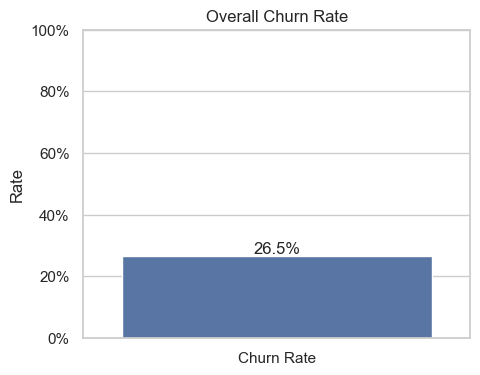

In [57]:
plt.figure(figsize=(5, 4))
rate = df["Churn"].mean()
ax = sns.barplot(x=["Churn Rate"], y=[rate])
ax.set_ylim(0, 1)
ax.set_title("Overall Churn Rate")
ax.set_ylabel("Rate")
ax.set_xlabel("")
ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
ax.bar_label(ax.containers[0], labels=[f"{rate:.1%}"])
plt.show()

In [59]:
%matplotlib inline

sns.set_style("whitegrid")

def plot_churn_rate_by_service(df, service_col):
    tbl = (
        df.groupby(service_col)["Churn"]
          .mean()
          .sort_values(ascending=False)
          .reset_index()
    )

    print(tbl)  # sanity check

    plt.figure(figsize=(7, 4))
    ax = sns.barplot(data=tbl, x=service_col, y="Churn")
    ax.set_ylim(0, 1)
    ax.set_title(f"Churn Rate by {service_col}")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0%}")

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width()/2., p.get_height()),
            ha="center", va="bottom"
        )

    plt.xticks(rotation=15)
    plt.show()  # ← REQUIRED

  InternetService     Churn
0     Fiber optic  0.418928
1             DSL  0.189591
2              No  0.074050


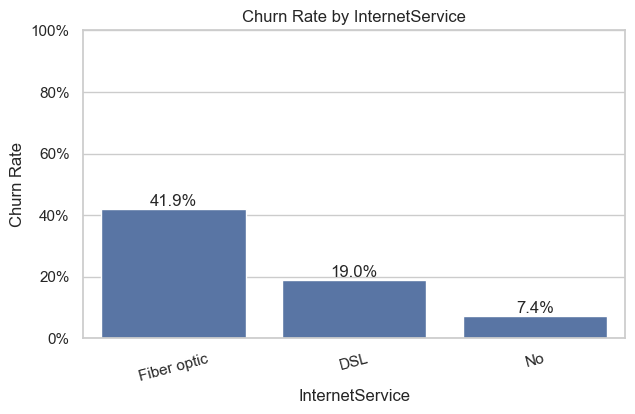

        OnlineSecurity     Churn
0                   No  0.417667
1                  Yes  0.146112
2  No internet service  0.074050


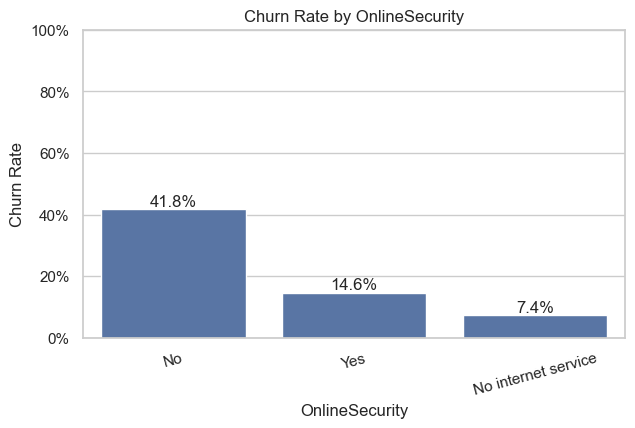

           TechSupport     Churn
0                   No  0.416355
1                  Yes  0.151663
2  No internet service  0.074050


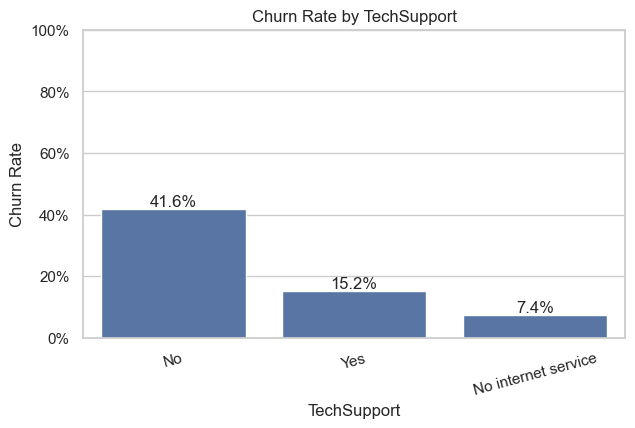

           StreamingTV     Churn
0                   No  0.335231
1                  Yes  0.300702
2  No internet service  0.074050


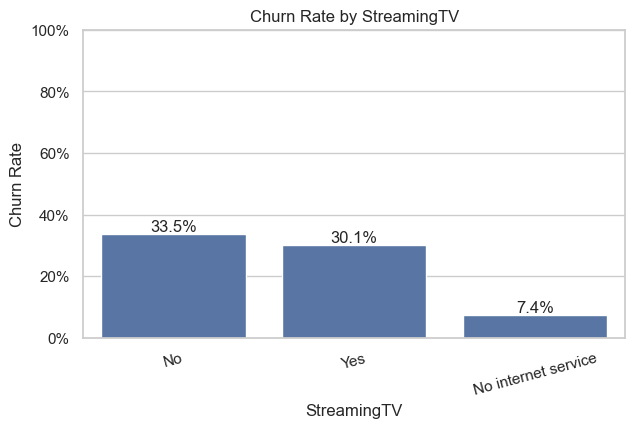

       StreamingMovies     Churn
0                   No  0.336804
1                  Yes  0.299414
2  No internet service  0.074050


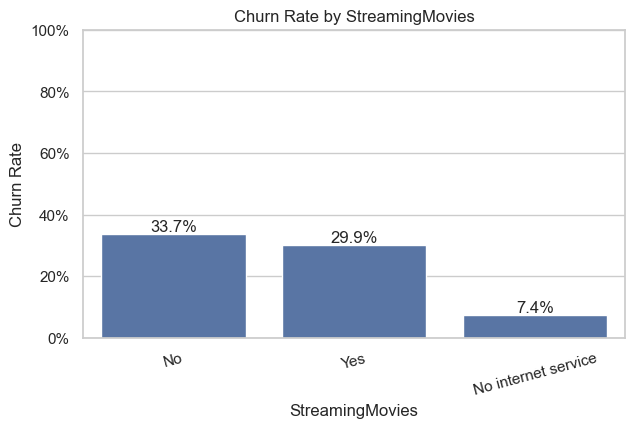

          OnlineBackup     Churn
0                   No  0.399288
1                  Yes  0.215315
2  No internet service  0.074050


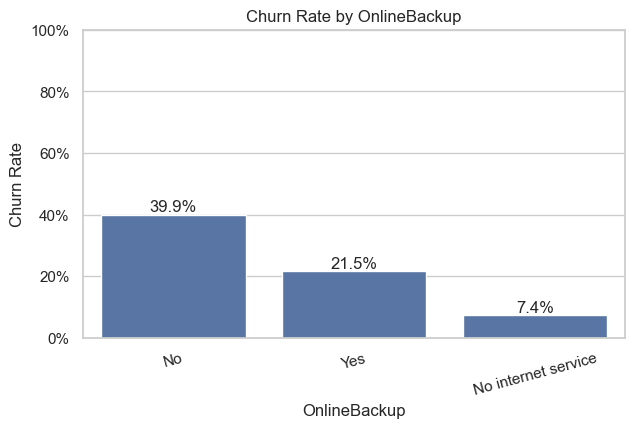

      DeviceProtection     Churn
0                   No  0.391276
1                  Yes  0.225021
2  No internet service  0.074050


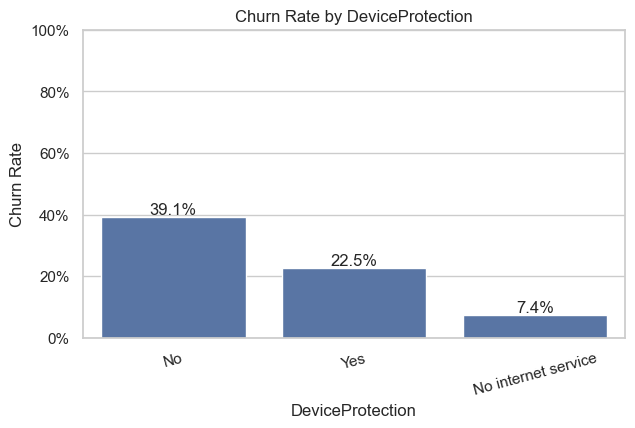

In [61]:
services = [
    "InternetService",
    "OnlineSecurity",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "OnlineBackup",
    "DeviceProtection"
]

for service in services:
    plot_churn_rate_by_service(df, service)

# Churn Rate V/S Contract Type Analysis

In [67]:

def churn_rate_table(df: pd.DataFrame, col: str, churn_col: str = "Churn") -> pd.DataFrame:
    """
    Computes count and churn rate by a categorical column.
    Assumes churn_col is binary (0/1).
    """
    tmp = df[[col, churn_col]].dropna()
    grp = tmp.groupby(col)[churn_col]
    out = pd.DataFrame({
        "count": grp.size(),
        "churn_rate": grp.mean()
    }).sort_values("churn_rate", ascending=False)
    return out 

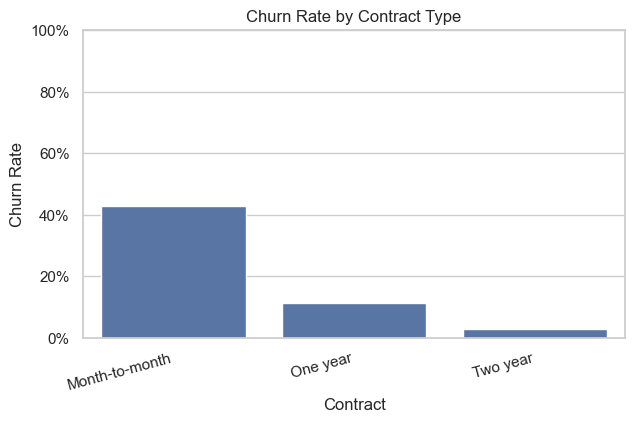

In [69]:
if "Contract" in df.columns:
    contract_tbl = churn_rate_table(df, "Contract")
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(x=contract_tbl.index, y=contract_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Contract Type")
    ax.set_xlabel("Contract")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.xticks(rotation=15, ha="right")
    plt.show()

# Churn Rate V/S Tenure Bucket Analysis

C:\Users\12146\AppData\Local\Temp\ipykernel_60144\3333803391.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = tmp.groupby(col)[churn_col]


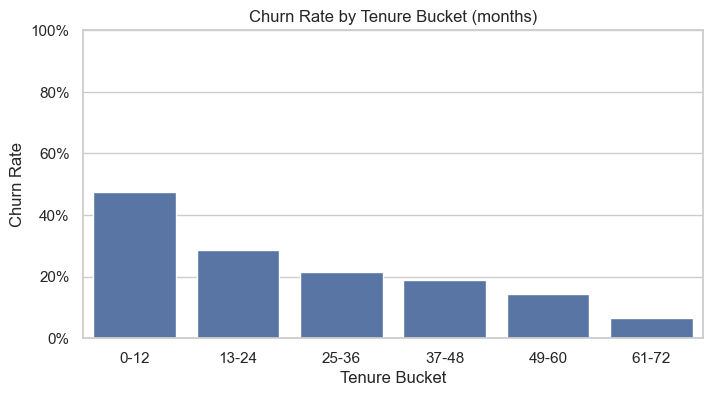

In [71]:
# Tenure buckets
# Bucket strategy (common): 0–12, 13–24, 25–36, 37–48, 49–60, 61–72
if "tenure" in df.columns:
    bins = [-0.1, 12, 24, 36, 48, 60, 72]
    labels = ["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"]
    df["tenure_bucket"] = pd.cut(df["tenure"], bins=bins, labels=labels)

    tenure_tbl = churn_rate_table(df, "tenure_bucket")
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=tenure_tbl.index.astype(str), y=tenure_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Tenure Bucket (months)")
    ax.set_xlabel("Tenure Bucket")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.show()

# Churn Rate V/S Payment Method Analysis

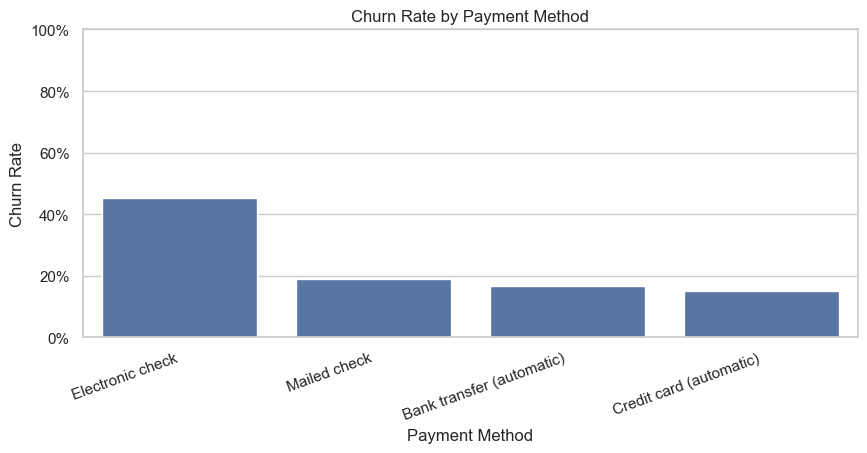

In [73]:
# Payment method
if "PaymentMethod" in df.columns:
    pay_tbl = churn_rate_table(df, "PaymentMethod")
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(x=pay_tbl.index, y=pay_tbl["churn_rate"].values)
    ax.set_ylim(0, 1)
    ax.set_title("Churn Rate by Payment Method")
    ax.set_xlabel("Payment Method")
    ax.set_ylabel("Churn Rate")
    ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    plt.xticks(rotation=20, ha="right")
    plt.show()

# Distribution of Monthly chargers: Tenure Split by Churn

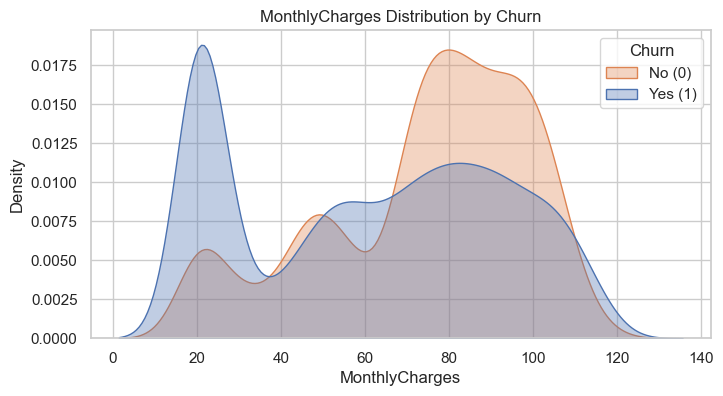

In [79]:
# 3) Distributions: MonthlyCharges, tenure split by churn
# -------------------------
# MonthlyCharges distribution split by churn
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", common_norm=False, fill=True, alpha=0.35)
    plt.title("MonthlyCharges Distribution by Churn")
    plt.xlabel("MonthlyCharges")
    plt.ylabel("Density")
    plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
    plt.show()



# Tenure Distribution by Churn

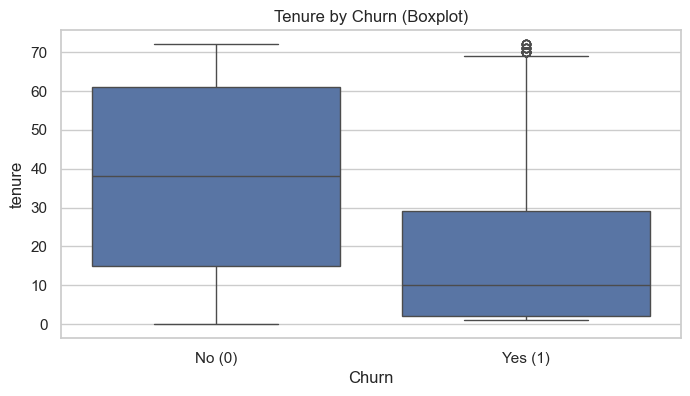

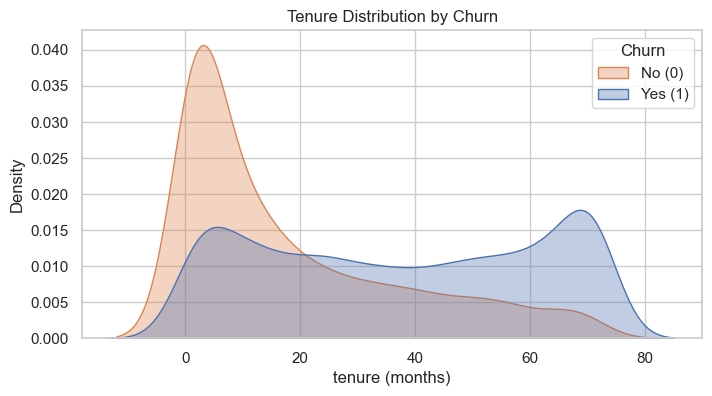

C:\Users\12146\AppData\Local\Temp\ipykernel_60144\2798956954.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No (0)", "Yes (1)"])


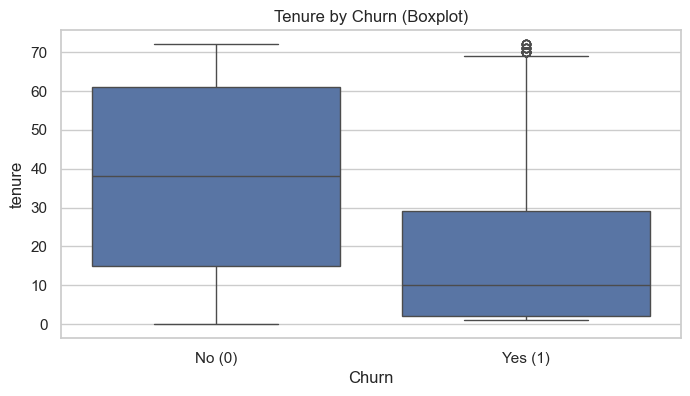

In [83]:
# Tenure distribution split by churn
if "tenure" in df.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x="tenure", hue="Churn", common_norm=False, fill=True, alpha=0.35)
    plt.title("Tenure Distribution by Churn")
    plt.xlabel("tenure (months)")
    plt.ylabel("Density")
    plt.legend(title="Churn", labels=["No (0)", "Yes (1)"])
    plt.show()

    plt.figure(figsize=(8, 4))
    ax = sns.boxplot(data=df, x="Churn", y="tenure")
    ax.set_xticklabels(["No (0)", "Yes (1)"])
    ax.set_title("Tenure by Churn (Boxplot)")
    plt.show()

# Correlation Heatmap for Numeric features

NameError: name 'savefig' is not defined

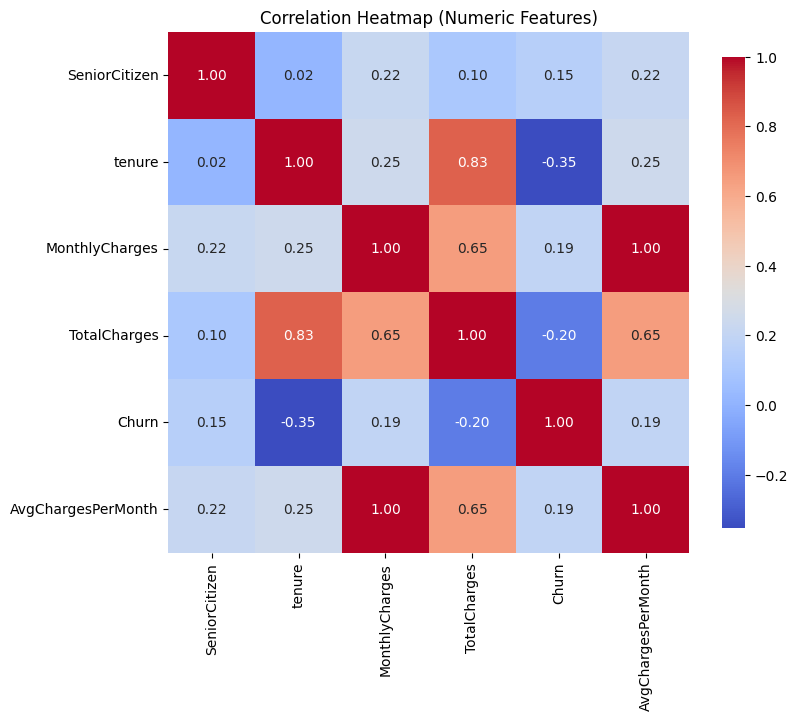

In [47]:
# 4) Correlation heatmap for numeric features
# -------------------------
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Keep it readable: typically numeric columns include: tenure, MonthlyCharges, TotalCharges, Churn
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)

    plt.figure(figsize=(6 + 0.4 * len(num_cols), 5 + 0.3 * len(num_cols)))
    ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.9})
    ax.set_title("Correlation Heatmap (Numeric Features)")
    plt.show()
else:
    print("Not enough numeric columns found for correlation heatmap.")

print("\nDone. Tip: set SAVE_PLOTS=True to export PNGs.")

##### “The correlation heatmap shows that tenure and TotalCharges are moderately to strongly negatively correlated with churn, indicating that long-term customers are less likely to leave. MonthlyCharges shows a mild positive correlation with churn. Strong correlation between tenure and TotalCharges suggests potential multicollinearity, which should be considered during model selection.”

#### Each cell = correlation coefficient (Pearson r) between two variables

#### Values range from –1 to +1

#### Value range	Meaning
#### +1.0	Perfect positive relationship
#### 0.7 to 0.9	Strong positive
#### 0.3 to 0.6	Moderate positive
#### –0.3 to –0.6	Moderate negative
#### –0.7 to –0.9	Strong negative
#### 0	No linear relationship

##### Tenure ↔ Churn = -0.35
##### 📌 Interpretation:
##### Negative → as tenure increases, churn decreases
##### Moderate strength
##### Customers who stay longer are less likely to churn
##### This aligns with business intuition ✔️

##### Feature	Correlation with Churn	Meaning
##### tenure	            Negative	           Long-term customers churn less
##### MonthlyCharges	 Mild positive	           Higher bills → more churn
##### TotalCharges	 Strong negative	       Proxy for long tenure

##### 💡 Key insight: TotalCharges and tenure are highly correlated with each other, so don’t over-interpret both independently.